In [1]:
import os
import cv2
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tensorflow.keras.models import Model, load_model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

/var/folders/5t/zmhvg7g5415b4cn9r306nd400000gn/T/ipykernel_35241/2826079880.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


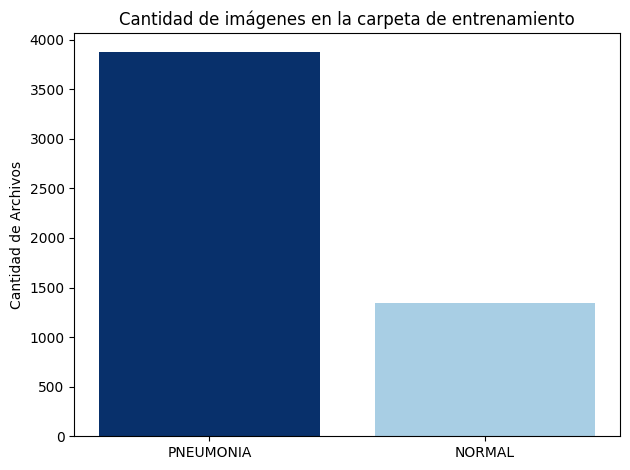

In [ ]:
# Ruta de la carpeta principal
ruta_carpeta_principal = '/path/to/chest_xray/train'

# Obtener las subcarpetas dentro de la carpeta principal
subcarpetas = [f.path for f in os.scandir(ruta_carpeta_principal) if f.is_dir()]

# Contar los archivos en cada subcarpeta
cantidad_archivos = {}
for subcarpeta in subcarpetas:
    nombre_subcarpeta = os.path.basename(subcarpeta)
    cantidad_archivos[nombre_subcarpeta] = len([f for f in os.listdir(subcarpeta) if os.path.isfile(os.path.join(subcarpeta, f))])

# Crear la gráfica de barras
colormap = cm.get_cmap('Blues')
valores_normalizados = [cantidad / max(cantidad_archivos.values()) for cantidad in cantidad_archivos.values()]
colores = colormap(valores_normalizados)

plt.bar(cantidad_archivos.keys(), cantidad_archivos.values(), color=colores)
plt.ylabel('Cantidad de Archivos')
plt.title('Cantidad de imágenes en la carpeta de entrenamiento')
plt.tight_layout()
plt.show()

/var/folders/5t/zmhvg7g5415b4cn9r306nd400000gn/T/ipykernel_35241/878766386.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


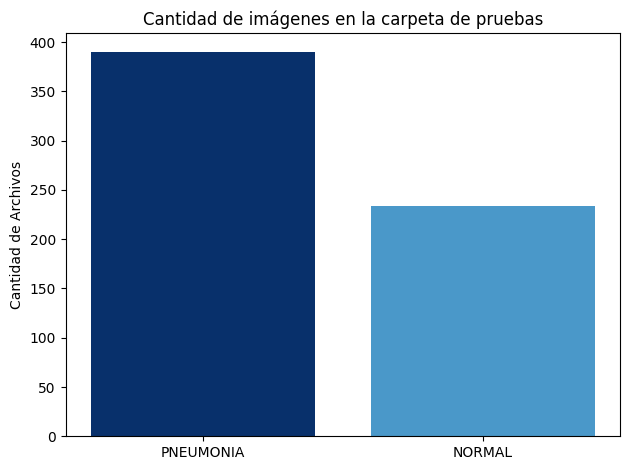

In [ ]:
# Ruta de la carpeta principal
ruta_carpeta_principal = '/path/to/chest_xray/test'

# Obtener las subcarpetas dentro de la carpeta principal
subcarpetas = [f.path for f in os.scandir(ruta_carpeta_principal) if f.is_dir()]

# Contar los archivos en cada subcarpeta
cantidad_archivos = {}
for subcarpeta in subcarpetas:
    nombre_subcarpeta = os.path.basename(subcarpeta)
    cantidad_archivos[nombre_subcarpeta] = len([f for f in os.listdir(subcarpeta) if os.path.isfile(os.path.join(subcarpeta, f))])

# Crear la gráfica de barras
colormap = cm.get_cmap('Blues')
valores_normalizados = [cantidad / max(cantidad_archivos.values()) for cantidad in cantidad_archivos.values()]
colores = colormap(valores_normalizados)

plt.bar(cantidad_archivos.keys(), cantidad_archivos.values(), color=colores)
plt.ylabel('Cantidad de Archivos')
plt.title('Cantidad de imágenes en la carpeta de pruebas')
plt.tight_layout()
plt.show()

In [ ]:
# Configuración básica
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 50

# Generadores de datos con aumentación
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Generador de entrenamiento
train_generator = train_datagen.flow_from_directory(
    '/path/to/chest_xray/train',
    color_mode='grayscale',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# Generador de validación
val_generator = train_datagen.flow_from_directory(
   '/path/to/chest_xray/test',
    color_mode='grayscale',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [5]:
# Definición del modelo

# Definir las dimensiones de entrada
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 1)

# Entrada
inputs = Input(shape=input_shape)

# Capa 1
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Capa 2
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Capa 3
x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Capa 4
x = Conv2D(256, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Capa 5
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)

# Capa 6
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

# Capa 7
x = Dense(32, activation='relu')(x)

# Capa de salida
outputs = Dense(1, activation='sigmoid')(x)

# Crear el modelo
model = Model(inputs=inputs, outputs=outputs)

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Callbacks para mejorar el entrenamiento
callbacks = [
    EarlyStopping(monitor='val_loss', 
                  patience=5, 
                  restore_best_weights=True),
    ModelCheckpoint('path/to/cnn_neumonía.keras', 
                    save_best_only=True)
]

# Obtener todas las etiquetas reales del dataset
y_train = train_generator.classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)

# Entrenamiento
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

Class weights: {0: 1.9445479962721341, 1: 0.6730645161290323}
Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 789ms/step - accuracy: 0.7907 - loss: 0.5789 - val_accuracy: 0.7430 - val_loss: 1.7108
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 106s 799ms/step - accuracy: 0.8894 - loss: 0.2883 - val_accuracy: 0.7430 - val_loss: 4.8535
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 793ms/step - accuracy: 0.9001 - loss: 0.2646 - val_accuracy: 0.7430 - val_loss: 5.9902
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 794ms/step - accuracy: 0.9035 - loss: 0.2334 - val_accuracy: 0.7430 - val_loss: 3.2111
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 796ms/step - accuracy: 0.9097 - loss: 0.2146 - val_accuracy: 0.8265 - val_loss: 0.4824
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 793ms/step - accuracy: 0.9236 - loss: 0.1880 - val_accuracy: 0.9243 - val_loss: 0.1791
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 796ms/step - accuracy: 0.9329 - loss: 0.1975 - val_accuracy: 0.9444 - val_loss: 0.1545
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 794ms/step - accuracy: 0.9272 - loss: 0.20

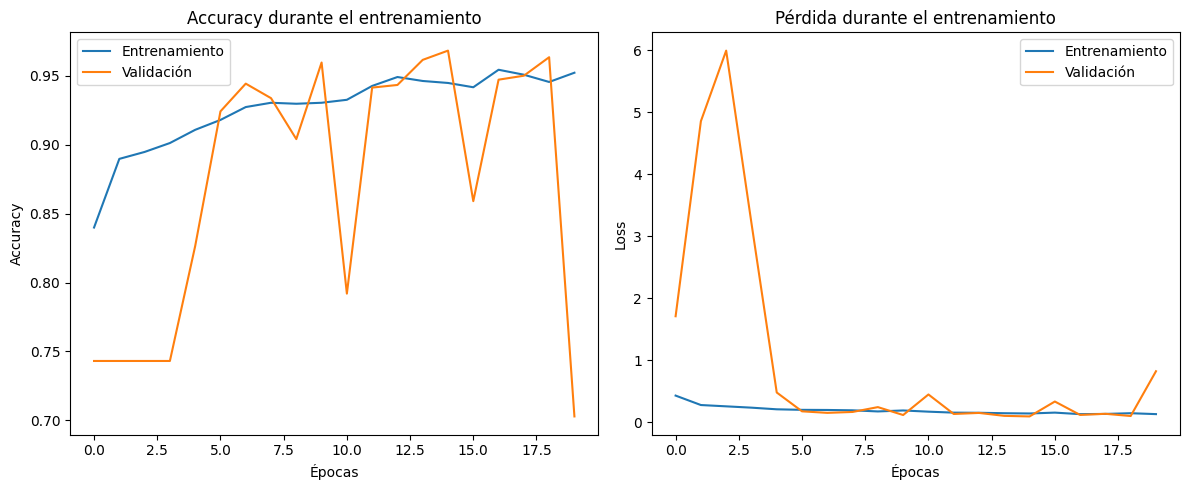

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Graficar accuracy
plt.figure(figsize=(12, 5))

# Accuracy vs Val_Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Entrenamiento')
plt.plot(val_acc, label='Validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Loss vs Val_Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluación antes de fine tune
loss, acc = model.evaluate(val_generator)
print(f"Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# Generador de datos para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/path/to/chest_xray/test',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

# Evaluar el modelo en el conjunto de prueba antes de fine tune
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba sin fine tune: {test_accuracy * 100:.2f}%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.9693 - loss: 0.0876
Loss: 0.0945, Accuracy: 0.9626
Found 624 images belonging to 2 classes.
624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8840 - loss: 0.3342
Precisión en el conjunto de prueba sin fine tune: 90.38%


In [ ]:
# Congelar las capas convolucionales inferiores
for layer in model.layers[:-4]:
    layer.trainable = False

callbacks = [
    EarlyStopping(monitor='val_loss', 
                  patience=3, 
                  restore_best_weights=True),
    ModelCheckpoint('/path/to/cnn_neumonía_ft.keras', 
                    save_best_only=True)
]

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar de nuevo con las capas superiores
fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 217ms/step - accuracy: 0.9574 - loss: 0.1257 - val_accuracy: 0.9569 - val_loss: 0.1035
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 220ms/step - accuracy: 0.9550 - loss: 0.1227 - val_accuracy: 0.9655 - val_loss: 0.0857
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 223ms/step - accuracy: 0.9556 - loss: 0.1176 - val_accuracy: 0.9655 - val_loss: 0.0959
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 223ms/step - accuracy: 0.9541 - loss: 0.1224 - val_accuracy: 0.9645 - val_loss: 0.0961
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - accuracy: 0.9641 - loss: 0.1090 - val_accuracy: 0.9578 - val_loss: 0.1043


In [15]:
# Evaluar el modelo en el conjunto de prueba con fine tune
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba con fine tune: {test_accuracy * 100:.2f}%")

624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8699 - loss: 0.4138
Precisión en el conjunto de prueba con fine tune: 90.06%


624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

      NORMAL       0.90      0.83      0.87       234
   PNEUMONIA       0.90      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.90       624
weighted avg       0.90      0.90      0.90       624



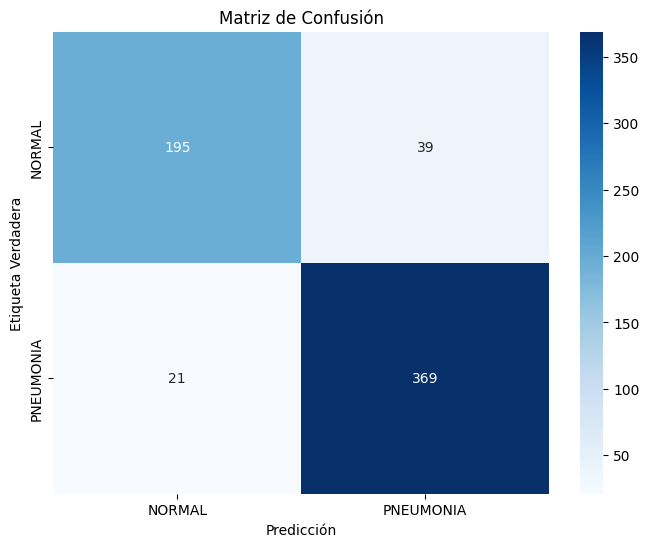

In [ ]:
# Generar predicciones
model_path = 'cnn_neumonía.keras'

model = load_model(model_path)

y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)
y_true = test_generator.classes

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Verdadera")
plt.show()

In [11]:
def grad_cam_bounding_boxes(model_path, img_path, img_size):
    # Cargar el modelo guardado
    model = load_model(model_path)

    # Cargar y preprocesar la imagen
    img = load_img(img_path, target_size=img_size, color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expandir a batch
    img_array = img_array / 255.0  # Normalizar

    # Seleccionar la última capa convolucional
    last_conv_layer = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]

    # Crear un modelo para mapear de la entrada al último mapa de características y predicción final
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )

    # Calcular los gradientes de la clase predicha respecto al mapa de características
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = predictions[0]
        loss = predicted_class

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Ponderar las activaciones del mapa de características con los gradientes
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)

    # Aplicar ReLU y normalizar
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)

    # Redimensionar el heatmap al tamaño de la imagen con suavizado
    heatmap = heatmap.numpy()
    heatmap_resized = tf.image.resize(
        tf.expand_dims(heatmap, axis=-1), img_size, method='bilinear'
    ).numpy().squeeze()

    # Aplicar un filtro gaussiano para suavizar las transiciones
    heatmap_smoothed = gaussian_filter(heatmap_resized, sigma=2)

    # Detectar las coordenadas de los bounding boxes
    threshold = 0.85
    binary_heatmap = heatmap_smoothed > threshold

    # Detectar componentes conectados
    num_labels, labels = cv2.connectedComponents(binary_heatmap.astype(np.uint8))

    bounding_boxes = []
    for label in range(1, num_labels):  # Ignorar el fondo (label 0)
        coords = np.argwhere(labels == label)
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
        bounding_boxes.append((x_min, y_min, x_max, y_max))

    # Convertir el heatmap en colores (JET)
    heatmap_color = plt.cm.jet(heatmap_smoothed)[:, :, :3] * 255

    # Superponer el heatmap en la imagen original con menor opacidad
    img_original = img_to_array(load_img(img_path, target_size=img_size, color_mode='grayscale')).squeeze()
    img_original = np.uint8(img_original / np.max(img_original) * 255)

    superimposed_img = heatmap_color * 0.4 + np.stack((img_original,) * 3, axis=-1) * 0.6
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    # Mostrar la imagen original con todos los bounding boxes
    plt.figure(figsize=(10, 5))

    # Imagen original con bounding boxes
    plt.subplot(1, 2, 1)
    plt.title("Imagen Original con Bounding Boxes")
    plt.imshow(img_original, cmap='gray')
    plt.axis('off')

    # Dibujar cada bounding box
    ax = plt.gca()
    for x_min, y_min, x_max, y_max in bounding_boxes:
        ax.add_patch(
            plt.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                fill=False, edgecolor='red', linewidth=2
            )
        )

    # Imagen superpuesta con Grad-CAM
    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(superimposed_img.astype('uint8'))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

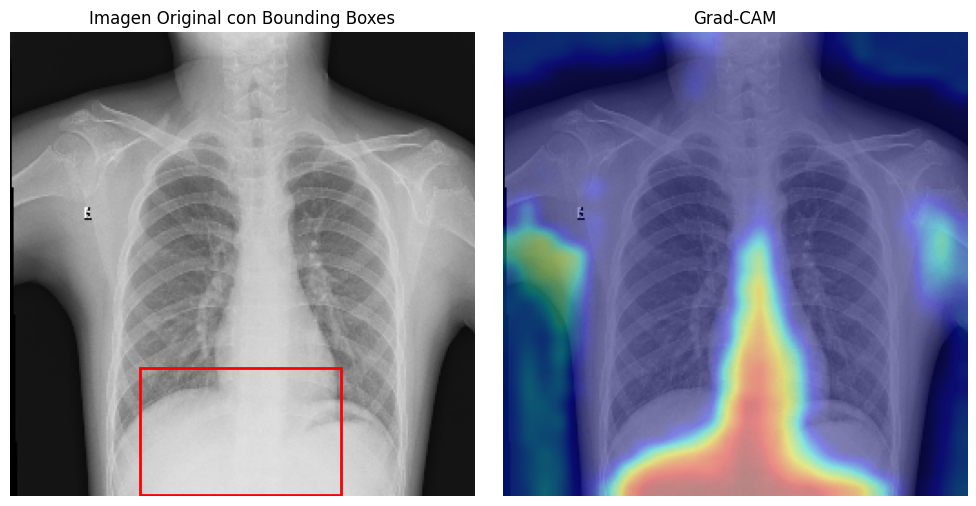

In [ ]:
img_path = '/path/to/chest_xray/test/NORMAL/NORMAL2-IM-0096-0001.jpeg'

grad_cam_bounding_boxes(model_path, img_path, IMG_SIZE)


In [13]:
def predict_random_images(model_path, train_dir, img_size, num_images):
    # Cargar el modelo
    model = load_model(model_path)

    # Carpetas de imágenes
    normal_dir = os.path.join(train_dir, 'NORMAL')
    pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

    # Obtener rutas de las imágenes
    normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
    pneumonia_images = [os.path.join(pneumonia_dir, img) for img in os.listdir(pneumonia_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

    # Mezclar y seleccionar imágenes al azar
    selected_images = random.sample(normal_images, num_images // 2) + random.sample(pneumonia_images, num_images // 2)
    random.shuffle(selected_images)  # Mezclar aleatoriamente

    # Crear una figura para mostrar las imágenes
    plt.figure(figsize=(20, 15))

    for i, img_path in enumerate(selected_images):
        # Cargar y procesar la imagen
        img = load_img(img_path, target_size=img_size, color_mode='grayscale')
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalizar

        # Realizar la predicción
        prediction = model.predict(img_array)[0][0]
        predicted_label = 'PNEUMONIA' if prediction >= 0.5 else 'NORMAL'

        # Obtener la etiqueta real de la carpeta
        actual_label = 'PNEUMONIA' if 'PNEUMONIA' in img_path else 'NORMAL'

        # Mostrar la imagen con la predicción y la etiqueta real
        plt.subplot(4, 4, i + 1)
        plt.imshow(img_array[0].squeeze(), cmap='gray')
        plt.title(f"Predicción: {predicted_label}\nActual: {actual_label}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


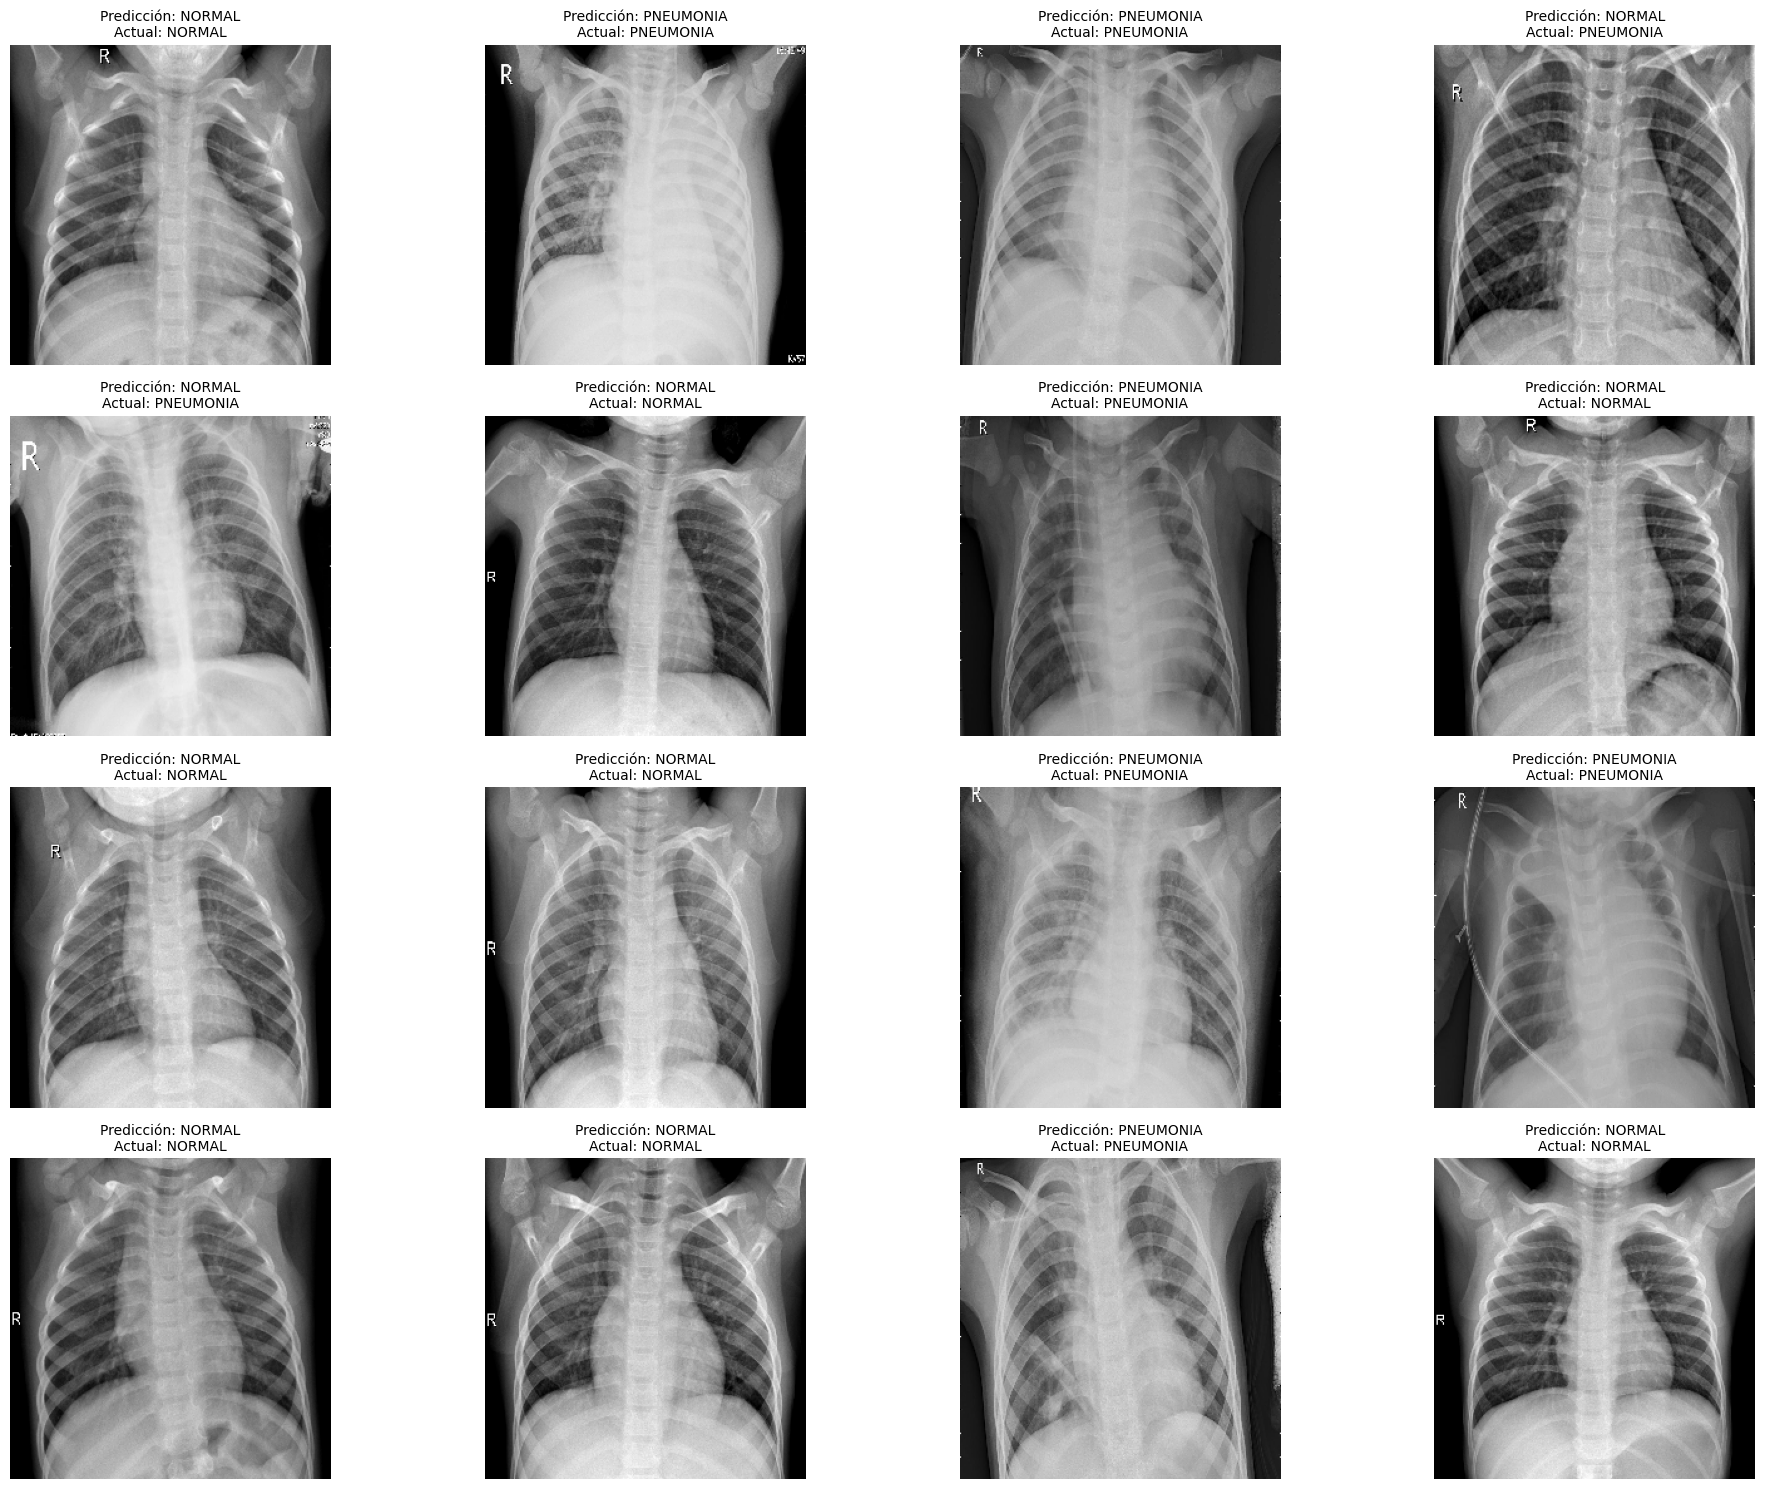

In [ ]:
train_dir = '/path/to/chest_xray/test'

predict_random_images(model_path, train_dir, IMG_SIZE, 16)